In [1]:
import numpy as np
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt


In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import keras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = "/content/drive/MyDrive/DATOS/train"
#test = "/content/drive/MyDrive/BDML/drowsiness-dataset/test"

In [5]:
labels = os.listdir(train)

In [6]:
labels

['Closed', 'bored', 'yawn', 'Open', 'drowsy', 'no_yawn']

# Visualize random

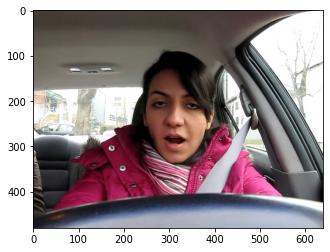

In [7]:
plt.imshow(plt.imread(f"{train}/yawn/10.jpg"))

In [8]:
a = plt.imread(f"{train}/yawn/10.jpg")
a.shape

(480, 640, 3)

In [9]:
def face_for_yawn(direc=train, face_cas_path='/content/drive/MyDrive/BDML/assets/haarcascade_frontalface_default.xml'):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


In [10]:
yawn_no_yawn = face_for_yawn()

0
1


In [11]:
def get_data(dir_path=train, face_cas='/content/drive/MyDrive/BDML/assets/haarcascade_frontalface_default.xml', eye_cas='/content/drive/MyDrive/BDML/assets/haarcascade_eye.xml'):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [12]:
data_train = get_data()

2
3


In [13]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [14]:
new_data = append_data()

0
1
2
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [15]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [16]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [17]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [18]:
y = np.array(y)

## train test split

In [19]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [20]:
X_train.shape, X_test.shape

((1347, 145, 145, 3), (578, 145, 145, 3))

## Data Augmentation

In [21]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

## Model

In [22]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

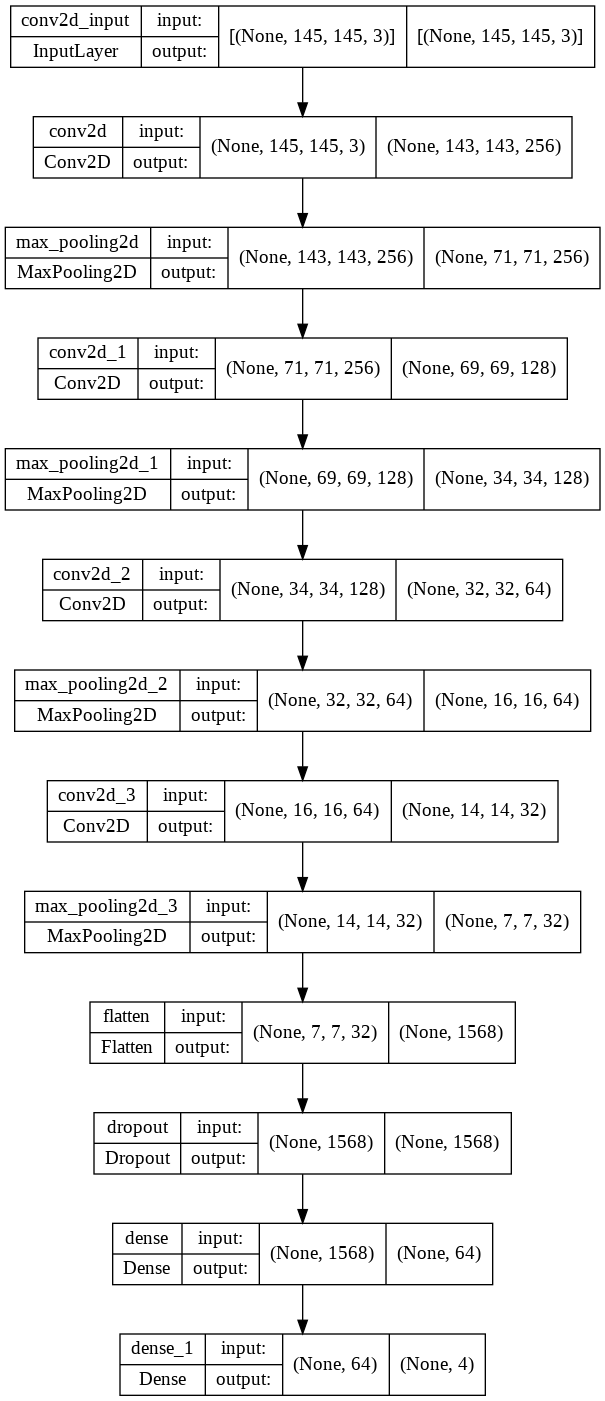

In [23]:
plot_model(model,show_shapes=True)

In [24]:
history = model.fit(train_generator, epochs=100, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/100
43/43 [==============================] - 23s 279ms/step - loss: 0.9882 - accuracy: 0.5553 - val_loss: 0.4607 - val_accuracy: 0.8374
Epoch 2/100
43/43 [==============================] - 11s 259ms/step - loss: 0.4964 - accuracy: 0.7914 - val_loss: 0.3678 - val_accuracy: 0.8754
Epoch 3/100
43/43 [==============================] - 11s 260ms/step - loss: 0.3903 - accuracy: 0.8337 - val_loss: 0.3331 - val_accuracy: 0.8789
Epoch 4/100
43/43 [==============================] - 12s 271ms/step - loss: 0.3234 - accuracy: 0.8656 - val_loss: 0.3795 - val_accuracy: 0.8737
Epoch 5/100
43/43 [==============================] - 11s 264ms/step - loss: 0.3342 - accuracy: 0.8582 - val_loss: 0.2379 - val_accuracy: 0.9170
Epoch 6/100
43/43 [==============================] - 11s 257ms/step - loss: 0.2804 - accuracy: 0.8812 - val_loss: 0.2404 - val_accuracy: 0.9221
Epoch 7/100
43/43 [==============================] - 11s 260ms/step - loss: 0.2904 - accuracy: 0.8812 - val_loss: 0.2404 - val_accuracy:

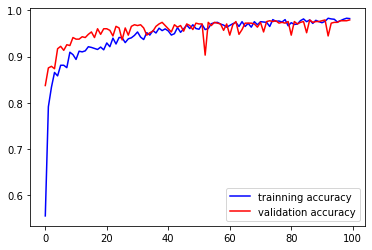

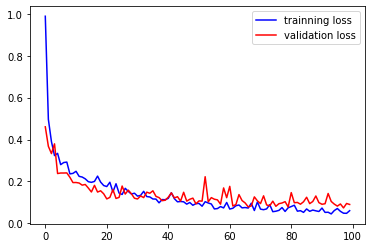

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

### Save Model

In [26]:
model.save("drowiness_complet.h5")

In [27]:
model.save("drowiness_comple.model")

INFO:tensorflow:Assets written to: drowiness_comple.model/assets


In [28]:
predict_x=model.predict(X_test) 
prediction=np.argmax(predict_x,axis=1)

In [29]:
prediction

array([3, 3, 0, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 1, 3, 0, 0, 3, 3, 3,
       2, 1, 1, 2, 2, 2, 3, 2, 3, 0, 3, 2, 0, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 3, 3, 3, 3, 3, 3, 1, 2, 0, 3, 3, 3, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 1, 2, 1, 3, 3, 3, 2, 0, 0, 3, 0, 3, 3, 0, 3, 2, 2, 2, 2, 0,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 1, 2, 2,
       1, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 3, 1, 1, 3, 3, 3, 2, 0, 3, 3,
       0, 3, 1, 2, 3, 3, 3, 1, 2, 2, 2, 1, 3, 3, 3, 3, 2, 0, 3, 3, 3, 3,
       3, 0, 1, 0, 3, 1, 3, 2, 2, 3, 2, 0, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 3, 0, 2, 3, 0, 3, 1, 3, 3, 3, 1, 2, 0, 1, 3, 2, 2, 3, 3, 3, 0,
       3, 2, 3, 1, 2, 0, 0, 0, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 1, 1,
       1, 0, 3, 3, 3, 3, 3, 0, 1, 2, 1, 0, 3, 3, 1, 3, 3, 0, 3, 3, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2,
       3, 2, 2, 0, 1, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 2,
       3, 1, 2, 2, 2, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

### Classification Report

In [30]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"] 

In [31]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.78      0.94      0.85        63
     no_yawn       0.87      0.88      0.87        74
      Closed       0.99      0.83      0.90       215
        Open       0.90      0.98      0.94       226

    accuracy                           0.91       578
   macro avg       0.88      0.91      0.89       578
weighted avg       0.91      0.91      0.91       578



### Predicting Function

In [32]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="/mnt/d/Bootcamp Python/FINAL PROJECT/Final-Project-BDML/Data/assets/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_complet.h5")

### 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [35]:
prediction = model.predict([prepare(f"{train}/Open/_3.jpg")])
results = ["Yawn","no Yawm","Closed","Open"]
print(results[np.argmax(prediction)])


Open
